# Representation Analysis

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['sans-serif']

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

DPI = 300

In [2]:
import torch
import os

#@markdown Execute this cell to check the Colab environment, including GPU availability.

# check gpu env
print(f"Torch: {torch.__version__} \n" + 
      f"Availability: {torch.cuda.is_available()}")
assert torch.cuda.is_available() == True, "The GPU is turned off. To turn it on, navigate to: Runtime > Change Runtime Type."
print(f"Number: {torch.cuda.device_count()} \n" +
      f"Current device: {torch.cuda.current_device()} \n" +
      f"First device: {torch.cuda.device(0)} \n" +
      f"Device name: {torch.cuda.get_device_name(0)}")

Torch: 2.2.0+cu121 
Availability: True
Number: 1 
Current device: 0 
First device: <torch.cuda.device object at 0x7fc9a1f6f650> 
Device name: NVIDIA GeForce RTX 3090


In [3]:
import fastai

fastai.__version__

'2.7.15'

In [4]:
import os
import math
import numpy as np
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import timm.data.transforms_factory as tff
from fastai.data.external import untar_data, URLs
from utils.utils import subsample

#@markdown Execute this cell to download and import the *Imagenette* dataset, which is a small subset of ImageNet, for simplicity.

# use imagenette (a small subset of imagenet) as an example for simplicity
imagenet_path = untar_data(URLs.IMAGENETTE_160)

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

transform_test = tff.transforms_imagenet_eval(
    img_size=192, mean=imagenet_mean, std=imagenet_std,
)

test_dir = os.path.join(imagenet_path, 'val')
dataset_test = datasets.ImageFolder(test_dir, transform_test)
dataset_test = torch.utils.data.Subset(
    dataset_test, 
    subsample(dataset_test, ratio=math.pow(2,-6))  # use a subsampled batch
)

dataset_test = DataLoader(
    dataset_test, 
    num_workers=1, 
    batch_size=16,
)

/home/ml/miniconda3/envs/representation_analysis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the Models

In [5]:
# MoCo
import torch
import models.moco as moco
from models.moco import load_state_dict
from utils.utils import download
import torchvision


#@markdown Execute this cell to download and import MoCo-v3 pre-trained model.

name = "moco_vit_b"  #@param {type:"string"}
path = "checkpoints/moco_vit_b.pt"  #@param {type:"string"}
url = "https://dl.fbaipublicfiles.com/moco-v3/vit-b-300ep/vit-b-300ep.pth.tar"  #@param {type:"string"}

download(url, path, force=False)  # download checkpoints

model = moco.vit_base()
model = model.cuda()
model = model.eval()

state_dict = load_state_dict(path)
_ = model.load_state_dict(state_dict, strict=False)
model_moco = model.eval()

transform_moco = torchvision.transforms.Resize([224,224])


/home/ml/miniconda3/envs/representation_analysis/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
# KAMIM
import torch
from utils.config import parameters_base as parameters
import transformers

from models.simmim import ViTForMaskedImageModeling

DIMENSION = parameters['dimension']                                 # dimension of image
MODEL_PATCH_SIZE = parameters['model_patch_size']                   # patch size         
MASKING_PATCH_SIZE = parameters['masking_patch_size']               # masking patch size
MASK_RATIO = parameters['mask_ratio']                               # model masking ratio
INTERMEDIATE_SIZE = parameters['intermediate_size']                      # model patch size to conform with VIT specs

# model config
HIDDEN_SIZE = parameters['hidden_size']
HIDDEN_LAYERS = parameters['num_hidden_layer']
ATTN_HEADS = parameters['num_attention_heads']

config = transformers.ViTConfig(
    hidden_size = HIDDEN_SIZE,
    num_hidden_layers = HIDDEN_LAYERS,
    num_attention_heads= ATTN_HEADS,
    image_size = DIMENSION,
    patch_size = MODEL_PATCH_SIZE,
    intermediate_size= INTERMEDIATE_SIZE,
    num_channels= 3,
)

model = ViTForMaskedImageModeling(config)
model = model.cuda()
model = model.eval()

state_dict = torch.load(f'checkpoints/kamim_checkpoint_final.pth')
_ = model.load_state_dict(state_dict, strict=False)
model_kamim = model.vit

model_kamim = model_kamim.eval()

In [7]:
# SimMIM
import torch
from utils.config import parameters_base as parameters
import transformers

from models.simmim import ViTForMaskedImageModeling

DIMENSION = parameters['dimension']                                 # dimension of image
MODEL_PATCH_SIZE = parameters['model_patch_size']                   # patch size         
MASKING_PATCH_SIZE = parameters['masking_patch_size']               # masking patch size
MASK_RATIO = parameters['mask_ratio']                               # model masking ratio
INTERMEDIATE_SIZE = parameters['intermediate_size']                      # model patch size to conform with VIT specs

# model config
HIDDEN_SIZE = parameters['hidden_size']
HIDDEN_LAYERS = parameters['num_hidden_layer']
ATTN_HEADS = parameters['num_attention_heads']

config = transformers.ViTConfig(
    hidden_size = HIDDEN_SIZE,
    num_hidden_layers = HIDDEN_LAYERS,
    num_attention_heads= ATTN_HEADS,
    image_size = DIMENSION,
    patch_size = MODEL_PATCH_SIZE,
    intermediate_size= INTERMEDIATE_SIZE,
    num_channels= 3,
)

model = ViTForMaskedImageModeling(config)
model = model.cuda()
model = model.eval()

state_dict = torch.load('checkpoints/simmim_checkpoint_final.pth')
_ = model.load_state_dict(state_dict, strict=False)
model_simmim = model.vit

model_simmim = model_simmim.eval()

## Fourier Analysis

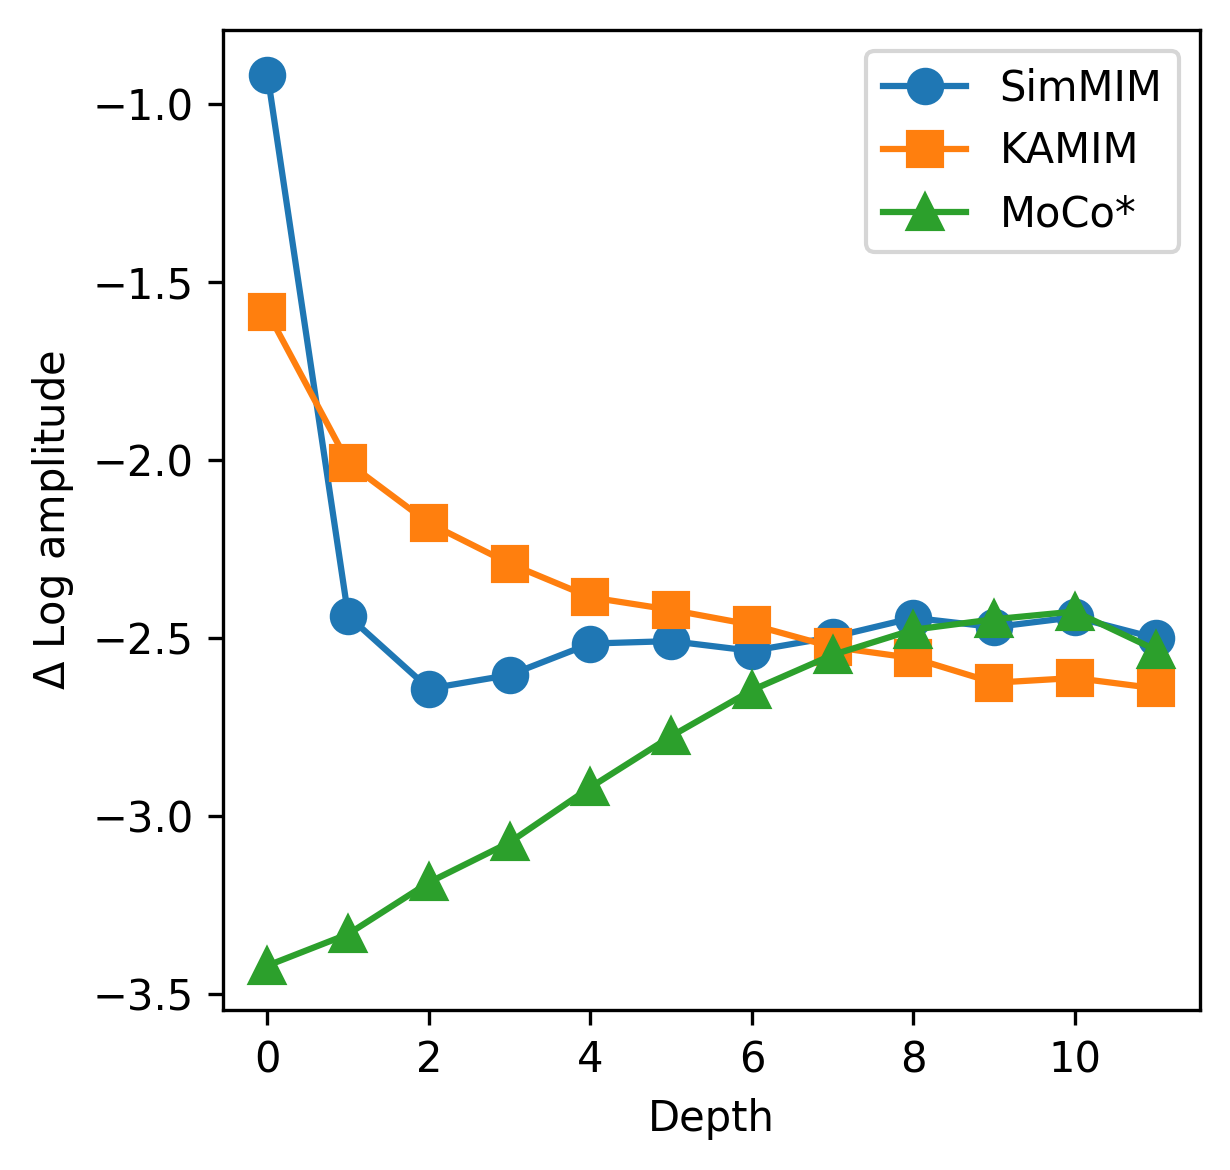

In [8]:
# build off the implementation of https://github.com/xxxnell/how-do-vits-work
import matplotlib.pyplot as plt
from einops import rearrange, reduce, repeat
from timm.utils import AverageMeter

def fourier(x):
    """2D Fourier transform"""
    f = torch.fft.fft2(x)
    f = f.abs() + 1e-6
    f = f.log()
    return f

def shift(x):  
    """shift Fourier transformed feature map"""
    b, c, h, w = x.shape
    return torch.roll(x, shifts=(int(h/2), int(w/2)), dims=(2, 3))

def get_fourier_latents(latents):
    """Fourier transform feature maps"""
    fourier_latents = []
    for latent in latents:  # `latents` is a list of hidden feature maps in latent spaces
        latent = latent.cpu()
        b, n, c = latent.shape
        h, w = int(math.sqrt(n)), int(math.sqrt(n))
        latent = rearrange(latent, "b (h w) c -> b c h w", h=h, w=w)
        
        latent = fourier(latent)
        latent = shift(latent).mean(dim=(0, 1))
        latent = latent.diag()[int(h/2):]  # only use the half-diagonal components
        latent = latent - latent[0]  # visualize 'relative' log amplitudes 
                                     # (i.e., low-freq amp - high freq amp)
        fourier_latents.append(latent)

    return fourier_latents
    
#@markdown Execute this cell to conduct Fourier analysis. The y-axis shows the amplitude (magnitude) of the high-frequency information. 
#@markdown 
#@markdown The results show that CL (MoCo) mainly exploits low-frequency information whereas MIM (SimMIM) exploits high-frequency information.

model_option = "kamim"  #@param ["kamim", "simmim"]
if model_option == "kamim":
    model = model_kamim
elif model_option == "simmim":
    model = model_simmim
else:
    raise Exception("Invalid option: ", model_option)

# SimMIM
fourier_latents_simmim = AverageMeter()
for i, (xs, ys) in enumerate(dataset_test):
    with torch.no_grad():
        xs = xs.cuda()
        zs = model_simmim(xs, output_hidden_states = True)['hidden_states']
        zs = zs[:-1]

    latents = [z[:,1:,:] for z in zs]
    _fourier_latents_simmim = torch.stack(get_fourier_latents(latents))
    fourier_latents_simmim.update(_fourier_latents_simmim)

    if i > -1:
        break
    
# kamim
fourier_latents_kamim = AverageMeter()
for i, (xs, ys) in enumerate(dataset_test):
    with torch.no_grad():
        xs = xs.cuda()
        zs = model_kamim(xs, output_hidden_states = True)['hidden_states']
        zs = zs[:-1]

    latents = [z[:,1:,:] for z in zs]
    _fourier_latents_kamim = torch.stack(get_fourier_latents(latents))
    fourier_latents_kamim.update(_fourier_latents_kamim)

    if i > -1:
        break
    
fourier_latents_moco = AverageMeter()
for i, (xs, ys) in enumerate(dataset_test):
    with torch.no_grad():
        xs_moco = transform_moco(xs).cuda()
        zs = model_moco(xs_moco)[1]
        zs = zs[:-1]

    latents = [z[:,1:,:] for z in zs]
    _fourier_latents_moco = torch.stack(get_fourier_latents(latents))
    fourier_latents_moco.update(_fourier_latents_moco)

    if i > -1:
        break
        
fig, ax = plt.subplots(1, 1, figsize=(4.2, 4), dpi=300)

fourier_latents_simmim = fourier_latents_simmim.avg
fourier_latents_kamim = fourier_latents_kamim.avg
fourier_latents_moco = fourier_latents_moco.avg

ax.plot(range(12), fourier_latents_simmim[:,-1], marker="o", label = 'SimMIM', markersize = 8)
ax.plot(range(12), fourier_latents_kamim[:,-1], marker="s", label = 'KAMIM', markersize = 8)
ax.plot(range(12), fourier_latents_moco[:,-1][::2][1:], marker="^", label = 'MoCo*', markersize = 8)

ax.set_xlabel("Depth")
ax.set_ylabel("$\Delta$ Log amplitude")
ax.legend()
# ax.set_ylim(top=-1.5, bottom=-3.5)
fig.tight_layout()
save_path = f'figures/'
os.makedirs(save_path, exist_ok=True, mode = 511)
plt.savefig(save_path + 'fourier_analysis.pdf', facecolor = 'white')

## Toekn-level t-SNE Visualization

In [9]:
with torch.no_grad():
    xs = xs.cuda()
    zs = model(xs, output_hidden_states = True, output_attentions = True)

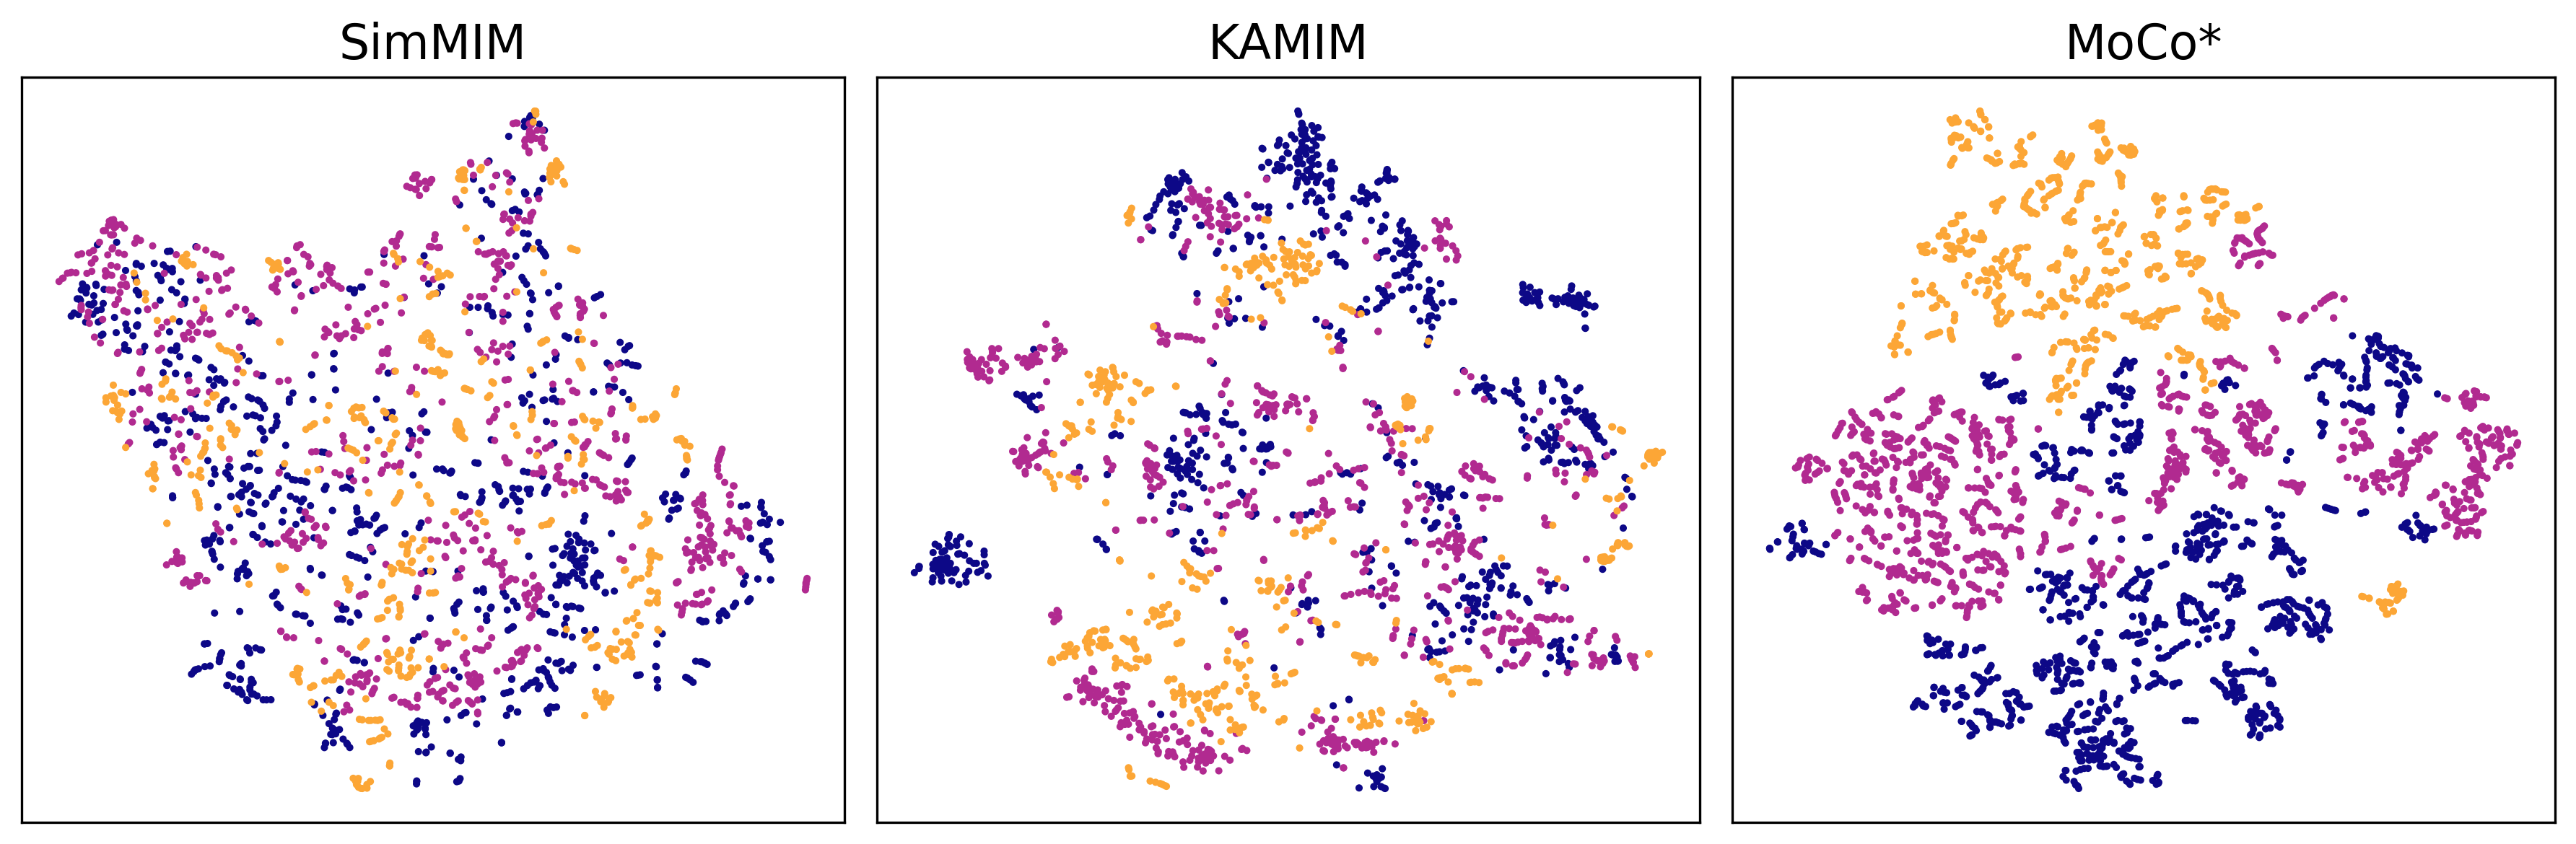

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.manifold import TSNE
from einops import rearrange, reduce, repeat

def visualize_token_tsne(ax, zs, depth, ys, cmap=matplotlib.colormaps["plasma"], size = 12): 
    latents = zs[depth]
    latents = latents[:,1:,:]  # drop cls
    latents = rearrange(latents, "b n c -> (b n) c",)
    latents = latents.cpu()
    
    reducer = TSNE(n_components=2, perplexity=20, learning_rate='auto', init='random', max_iter=1000)
    embedded = reducer.fit_transform(latents)
    
    labels = ys 
    labels = np.array([[label] * size * size for label in labels]).flatten()
    c = [cmap(label / (max(labels) + 0.5)) for label in labels]
    
    ax.scatter(embedded[:,0], embedded[:,1], c=c, s=2)
    
#@markdown Execute this cell to visualize token-level representations by using t-SNE. Note that we visualize 3,528 tokens (196 tokens×18 images) from the representations. 
#@markdown 
#@markdown The tokens of MoCo form a cluster for each image, while those of SimMIM are intermingled. This aligns with the finding that, compared to SimMIM, MoCo is linearly separable. The colors represent three different classes.

depth = 11  #@param {type:"slider", min:0, max:11, step:1}
model_option = 'simmim'
if model_option == "kamim":
    model = model_kamim
elif model_option == "simmim":
    model = model_simmim
else:
    raise Exception("Invalid option: ", model_option)


# sampling data
xs, ys = next(iter(dataset_test))

# create figure and axes
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=300)

with torch.no_grad():
    xs = xs.cuda()
    zs = model_simmim(xs, output_hidden_states = True)['hidden_states']
    zz = zs[:-1]
visualize_token_tsne(ax[0], zs, depth=depth, ys=ys, size=12)  # coloring at the image level

with torch.no_grad():
    xs = xs.cuda()
    zs = model_kamim(xs, output_hidden_states = True)['hidden_states']
    zs = zs[:-1]
visualize_token_tsne(ax[1], zs, depth=depth, ys=ys, size=12)  # coloring at the image level

with torch.no_grad():
    xs = transform_moco(xs).cuda()
    zs = model_moco(xs)[1]
    zs = zs[:-1]
visualize_token_tsne(ax[2], zs, depth=depth, ys=ys, size=14)  # coloring at the image level

ax[0].set_title("SimMIM", fontsize = 16)
ax[1].set_title("KAMIM", fontsize = 16)
ax[2].set_title("MoCo*", fontsize = 16)


ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

fig.tight_layout()
save_path = f'figures/'
plt.savefig(save_path + 'token_level_tsne.pdf', facecolor = 'white')

torch.Size([144, 768]) torch.Size([144, 768])
torch.Size([144, 768]) torch.Size([144, 768])
torch.Size([196, 768]) torch.Size([196, 768])


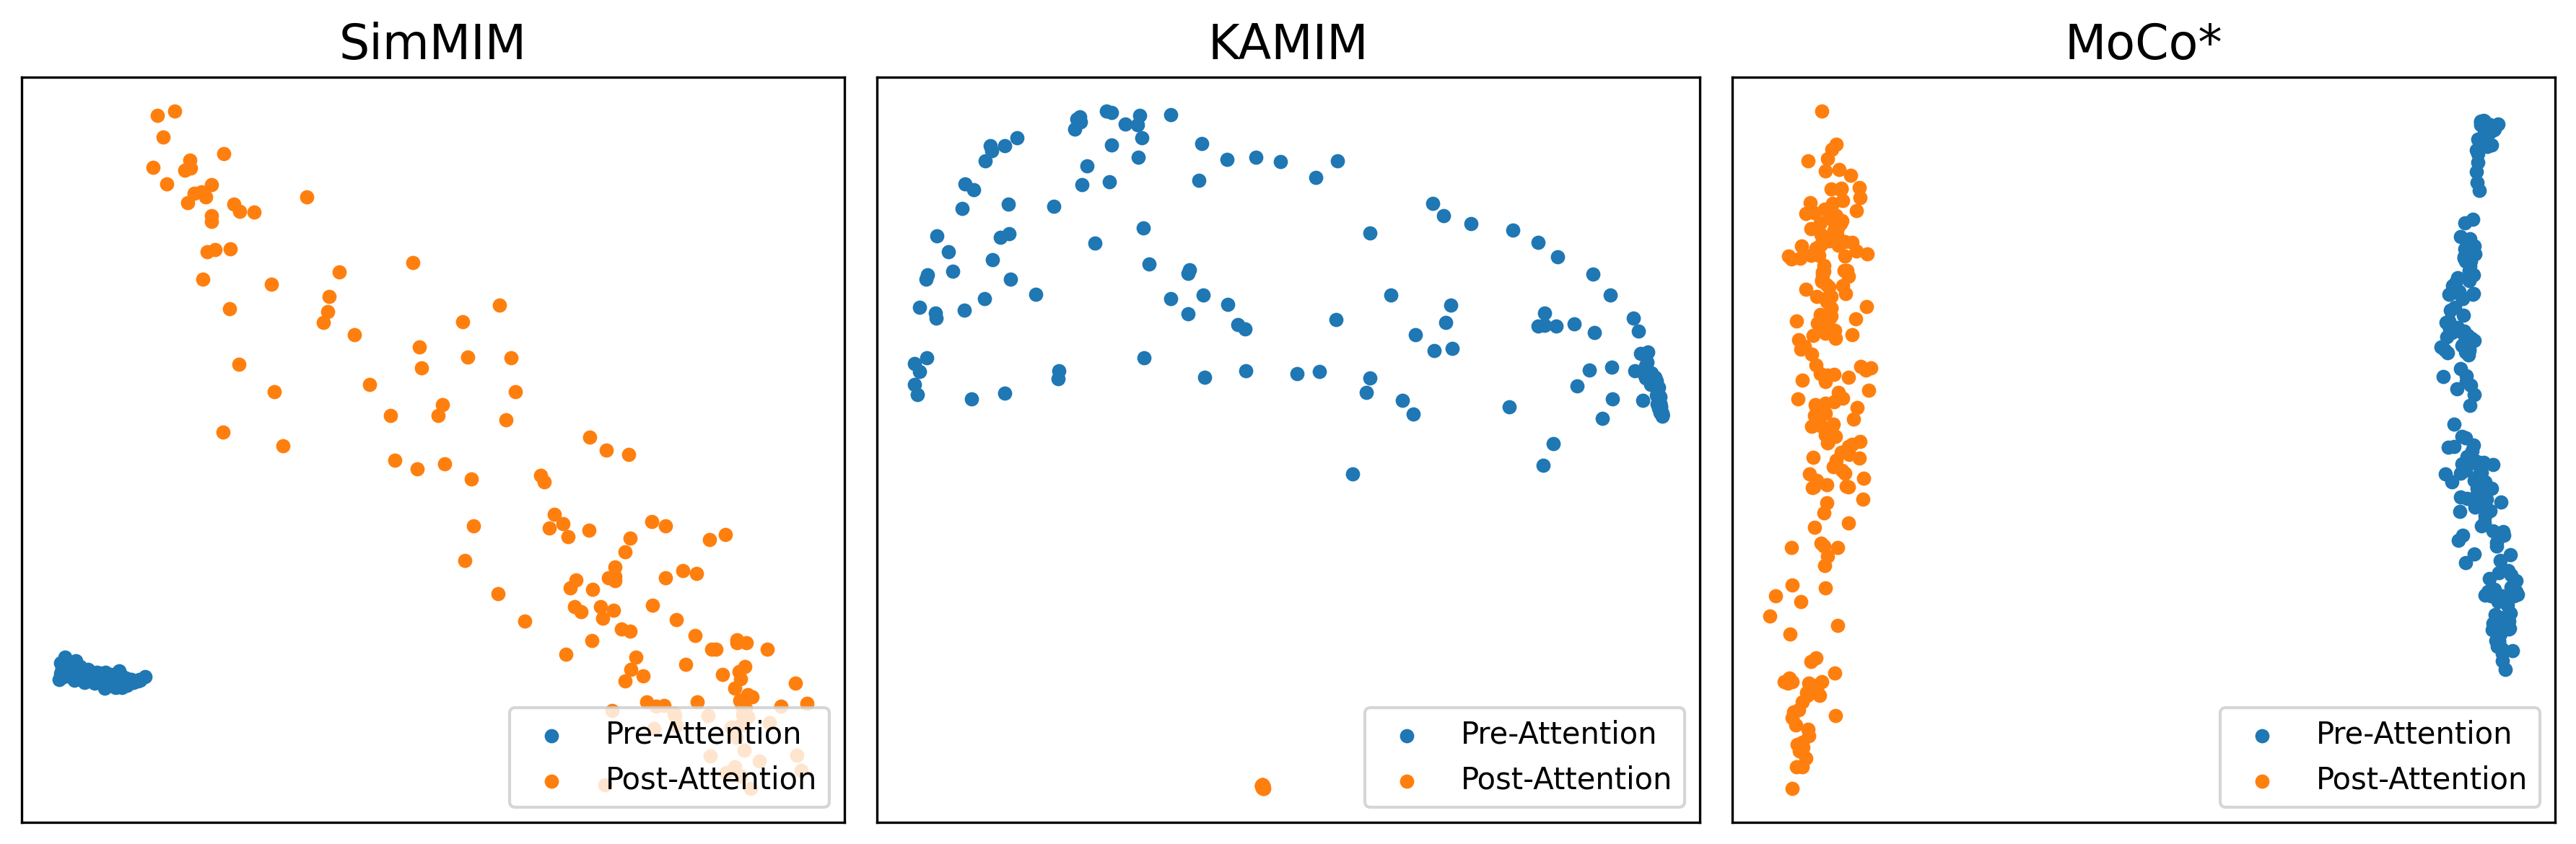

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from einops import rearrange, reduce, repeat

def visualize_token_pca_attn(ax, zs, attn, depth, b = 1, moco = False, cmap=matplotlib.colormaps["plasma"]): 
    if moco is False:
        pre_attn = attn[depth][0]
        pre_attn = pre_attn[:, 1:, :]
        pre_attn = pre_attn.cpu()
        
        post_attn = attn[depth][1]
        post_attn = post_attn[:,1:,:]  # drop cls
        post_attn = post_attn.cpu()
        
    else:
        pre_attn = attn[4][depth]
        pre_attn = pre_attn[:,1:,:]  # drop cls
        pre_attn = pre_attn.cpu()
        
        post_attn = attn[5][depth]
        post_attn = post_attn[:, 1:, :]
        post_attn = post_attn.cpu()

    # select one sample from the batch
    pre_attn = pre_attn[b]
    post_attn = post_attn[b]
    
    print(pre_attn.shape, post_attn.shape)
    
    all_latents = torch.vstack([pre_attn, post_attn]).numpy()
    # all_latents = RobustScaler().fit_transform(all_latents)
    
    # reducer = TSNE(n_components=2, perplexity=40, learning_rate='auto', init='random', max_iter=1000)
    
    reducer = PCA(n_components=2)
    embedded = reducer.fit_transform(all_latents)
    
    embedded_pre = embedded[:len(pre_attn)]     # 0 to half : precontrast
    embedded_post = embedded[len(post_attn):]   # half to end : postcontrast
    ax.scatter(embedded_pre[:,0], embedded_pre[:,1], s=14, label = 'Pre-Attention')
    ax.scatter(embedded_post[:,0], embedded_post[:,1], s=14, label = 'Post-Attention')

    # ax.scatter(embedded[:,0], embedded[:,1], c=c, s=12)

    
    
#@markdown Execute this cell to visualize token-level representations by using t-SNE. Note that we visualize 3,528 tokens (196 tokens×18 images) from the representations. 
#@markdown 
#@markdown The tokens of MoCo form a cluster for each image, while those of SimMIM are intermingled. This aligns with the finding that, compared to SimMIM, MoCo is linearly separable. The colors represent three different classes.

sample = 8
depth = 11  #@param {type:"slider", min:0, max:11, step:1}
model_option = 'simmim'
if model_option == "kamim":
    model = model_kamim
elif model_option == "simmim":
    model = model_simmim
else:
    raise Exception("Invalid option: ", model_option)

# sampling data
xs, ys = next(iter(dataset_test))

# create figure and axes
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=300)

# SimMIM
with torch.no_grad():
    xs = xs.cuda()
    out  = model_simmim(xs, output_hidden_states = True, output_attentions = True)
    zs = out['hidden_states']
    attn = out['attentions']
    zs = zs[:-1]
visualize_token_pca_attn(ax[0], zs, attn, depth=depth, b=sample)  # coloring at the image level

# kamim
with torch.no_grad():
    xs = xs.cuda()
    out  = model_kamim(xs, output_hidden_states = True, output_attentions = True)
    zs = out['hidden_states']
    attn = out['attentions']
    zs = zs[:-1]
visualize_token_pca_attn(ax[1], zs, attn, depth=depth, b=sample)  # coloring at the image level

# MoCo
with torch.no_grad():
    xs_moco = transform_moco(xs).cuda()
    outs_moco = model_moco(xs_moco)
    pre_attn = outs_moco[-2]
    post_attn = outs_moco[-1]
visualize_token_pca_attn(ax[2], None, outs_moco, depth=depth, b=sample, moco = True)  # coloring at the image level

ax[0].set_title("SimMIM", fontsize = 16)
ax[1].set_title("KAMIM", fontsize = 16)
ax[2].set_title("MoCo*", fontsize = 16)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

for a in ax:
    a.legend(loc = 'lower right')

fig.tight_layout()

save_path = f'figures/'
plt.savefig(save_path + 'tsne_transformation.pdf', facecolor = 'white')

## Supplementary figures

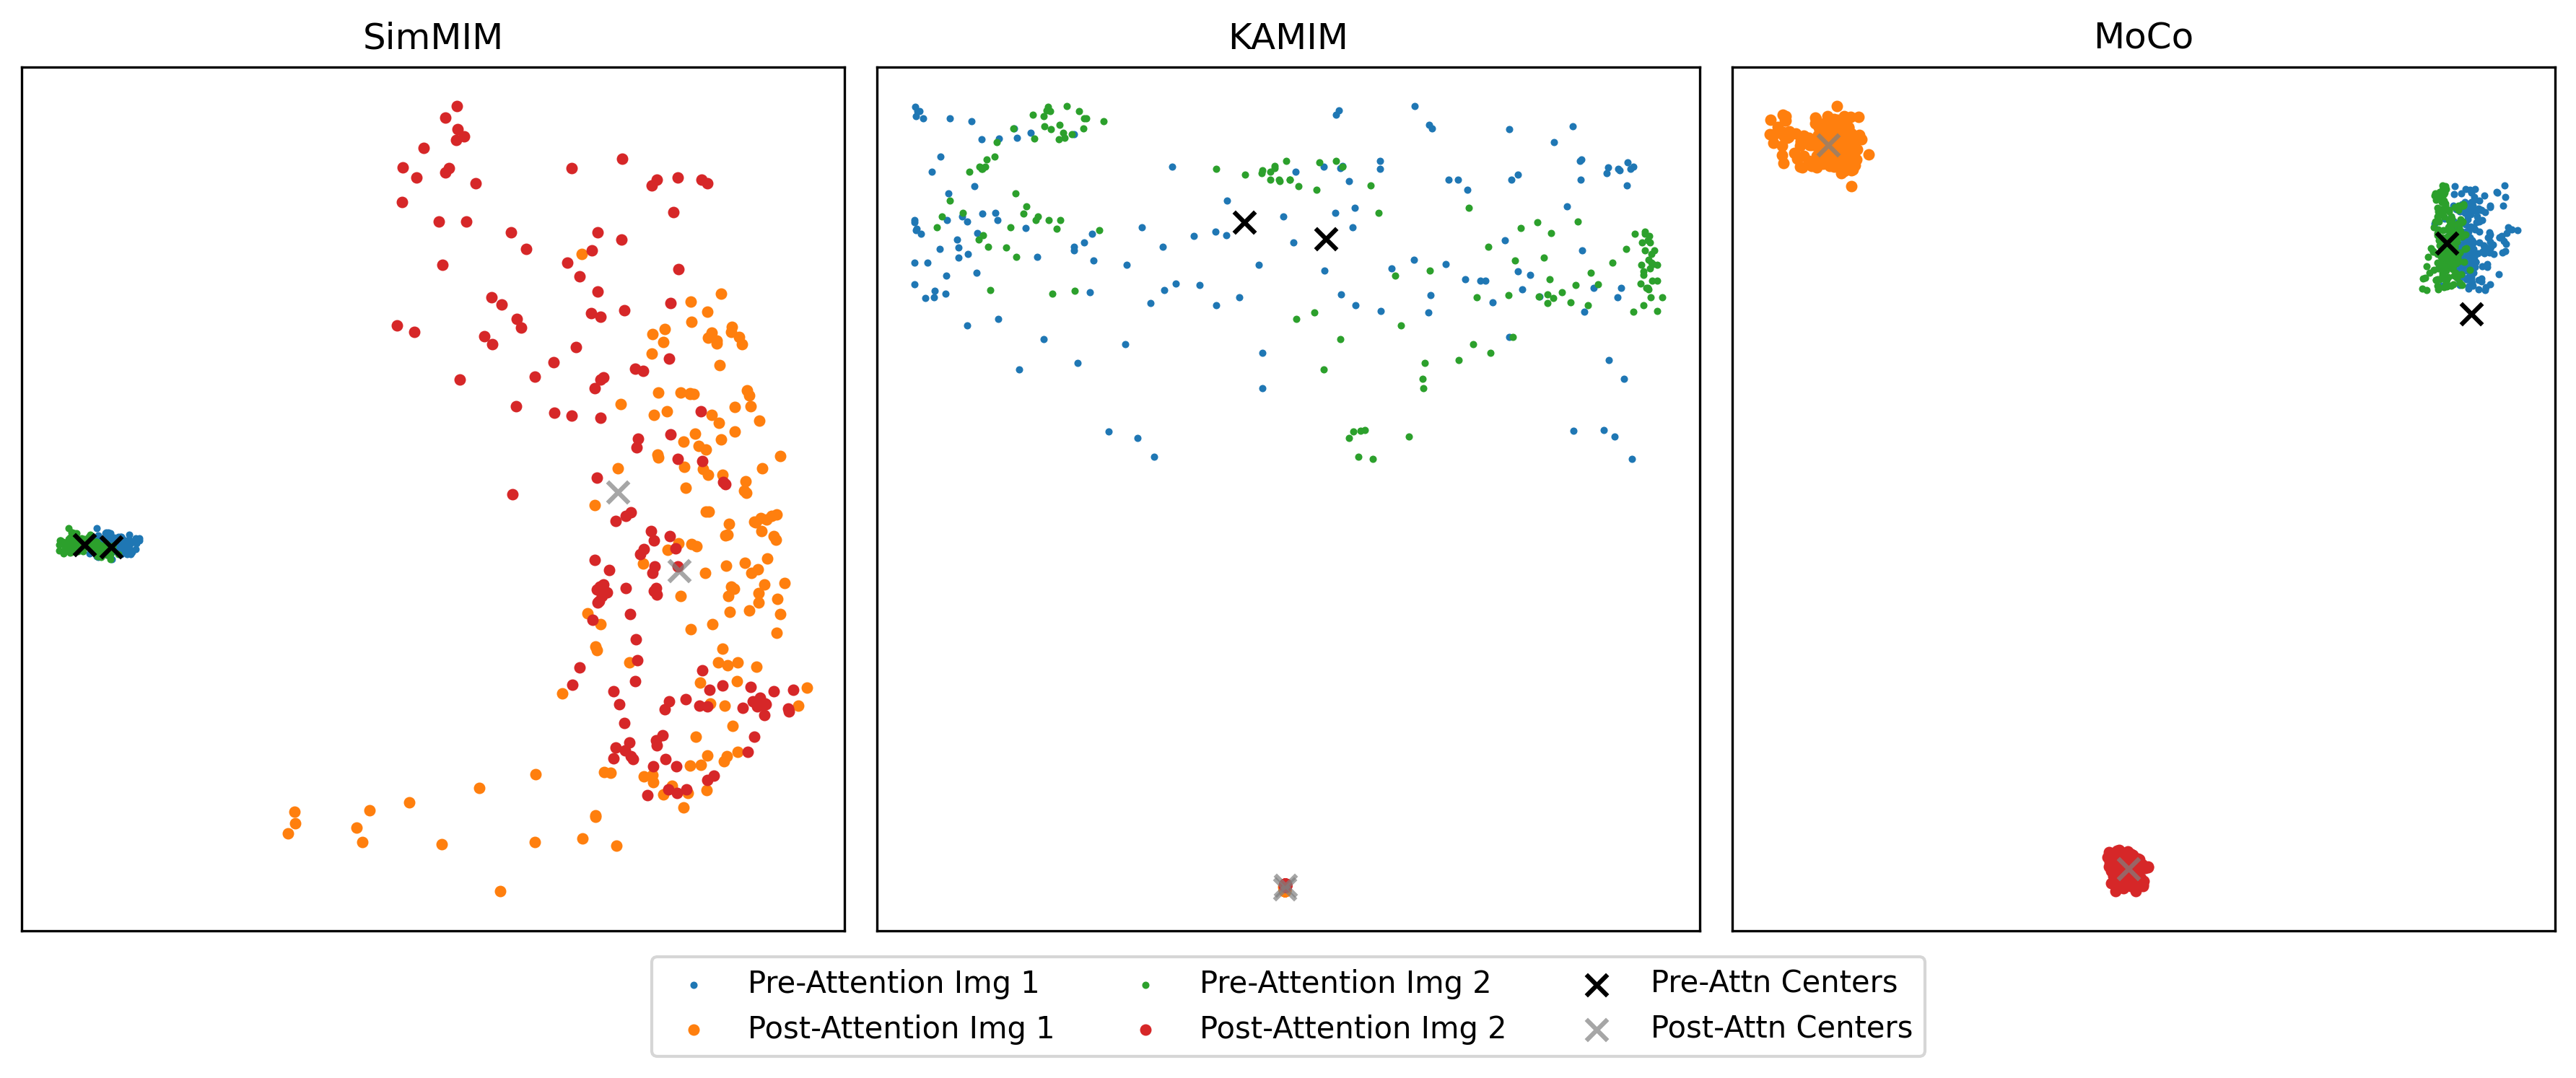

In [12]:
# visualizing KAMIM for two images
from sklearn.preprocessing import StandardScaler as Scaler

def visualize_token_pca_attn_two_imgs(ax, zs, attn, depth, b = [1, 9], moco = False, cmap=matplotlib.colormaps["plasma"]): 
    if moco is False:
        pre_attn = attn[depth][0]
        pre_attn = pre_attn[:, 1:, :]
        pre_attn = pre_attn.cpu()
        
        post_attn = attn[depth][1]
        post_attn = post_attn[:,1:,:]  # drop cls
        post_attn = post_attn.cpu()
        
    else:
        pre_attn = attn[4][depth]
        pre_attn = pre_attn[:,1:,:]  # drop cls
        pre_attn = pre_attn.cpu()
        
        post_attn = attn[5][depth]
        post_attn = post_attn[:, 1:, :]
        post_attn = post_attn.cpu()
    
    # select one sample from the batch
    pre_attn = pre_attn[b]
    post_attn = post_attn[b]
    
    all_latents = torch.vstack([pre_attn, post_attn]).numpy()
    n, emb, dim = all_latents.shape
    
    all_latents = all_latents.reshape(n*emb, dim)
    
    reducer = PCA(n_components=2)
    embedded = reducer.fit_transform(all_latents)
    
    embedded_pre_1 = embedded[:emb]                       # 0 to len(pre_attn) : first pre transform
    embedded_pre_2 = embedded[emb:2*emb]      # len(pre_attn) to 2*len(pre_attn) : second pre transform
    embedded_post_1 = embedded[2*emb:3*emb]   # 2*len(pre_attn) to 3*len(pre_attn) : first post transform
    embedded_post_2 = embedded[3*emb:]                   # 3*len(pre_attn) to end : second post transform
    
    mean_pre_1 = embedded_pre_1.mean(axis = 0).flatten()
    mean_pre_2 = embedded_pre_2.mean(axis = 0).flatten()
    mean_pre = np.vstack([mean_pre_1, mean_pre_2])

    mean_post_1 = embedded_post_1.mean(axis = 0).flatten()
    mean_post_2 = embedded_post_2.mean(axis = 0).flatten()
    mean_post = np.vstack([mean_post_1, mean_post_2])

    ax.scatter(embedded_pre_1[:,0], embedded_pre_2[:,1], s=8, label = 'Pre-Attention Img 1', marker = '.')
    ax.scatter(embedded_post_1[:,0], embedded_post_1[:,1], s=8, label = 'Post-Attention Img 1', marker = 'o')
    ax.scatter(embedded_pre_2[:,0], embedded_pre_2[:,1], s=8, label = 'Pre-Attention Img 2', marker = '.')
    ax.scatter(embedded_post_2[:,0], embedded_post_2[:,1], s=8, label = 'Post-Attention Img 2', marker = 'o')
    
    ax.scatter(mean_pre[:, 0], mean_pre[:, 1], s = 50, c = 'black', marker = 'x', label = 'Pre-Attn Centers')
    ax.scatter(mean_post[:, 0], mean_post[:, 1], s = 50, c = 'grey', marker = 'x', label = 'Post-Attn Centers', alpha = 0.7)

    
    # ax.legend(bbox_to_anchor=(1.04, 1))
   
 
xs, ys = next(iter(dataset_test))

fig, ax = plt.subplots(1,3, figsize = (12, 5), dpi=300)
ys_np = ys.numpy()

DEPTH = 11
b = [1, 13]

# SimMIM
with torch.no_grad():
    xs = xs.cuda()
    out  = model_simmim(xs, output_hidden_states = True, output_attentions = True)
    zs = out['hidden_states']
    attn = out['attentions']
    zs = zs[:-1]
visualize_token_pca_attn_two_imgs(ax[0], zs, attn, depth=DEPTH, b = b)  # coloring at the image level
ax[0].set_title("SimMIM")

# kamim
with torch.no_grad():
    xs = xs.cuda()
    out  = model_kamim(xs, output_hidden_states = True, output_attentions = True)
    zs = out['hidden_states']
    attn = out['attentions']
    zs = zs[:-1]
visualize_token_pca_attn_two_imgs(ax[1], zs, attn, depth=DEPTH, b = b)  # coloring at the image level
ax[1].set_title("KAMIM")

# moco
with torch.no_grad():
    xs_moco = transform_moco(xs).cuda()
    outs_moco = model_moco(xs_moco)
    pre_attn = outs_moco[-2]
    post_attn = outs_moco[-1]
visualize_token_pca_attn_two_imgs(ax[2], None, outs_moco, depth=DEPTH, b = b, moco = True)  # coloring at the image level
ax[2].set_title("MoCo")

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

handles, labels = ax[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor = (0.5,0), ncol = 3)

fig.tight_layout(rect = (0, 0.10, 1, 1))
save_path = 'supp_figures/'
fig.savefig(save_path + 'pre_post_attn_2_imgs.pdf', facecolor = 'white')

In [13]:
ys

tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

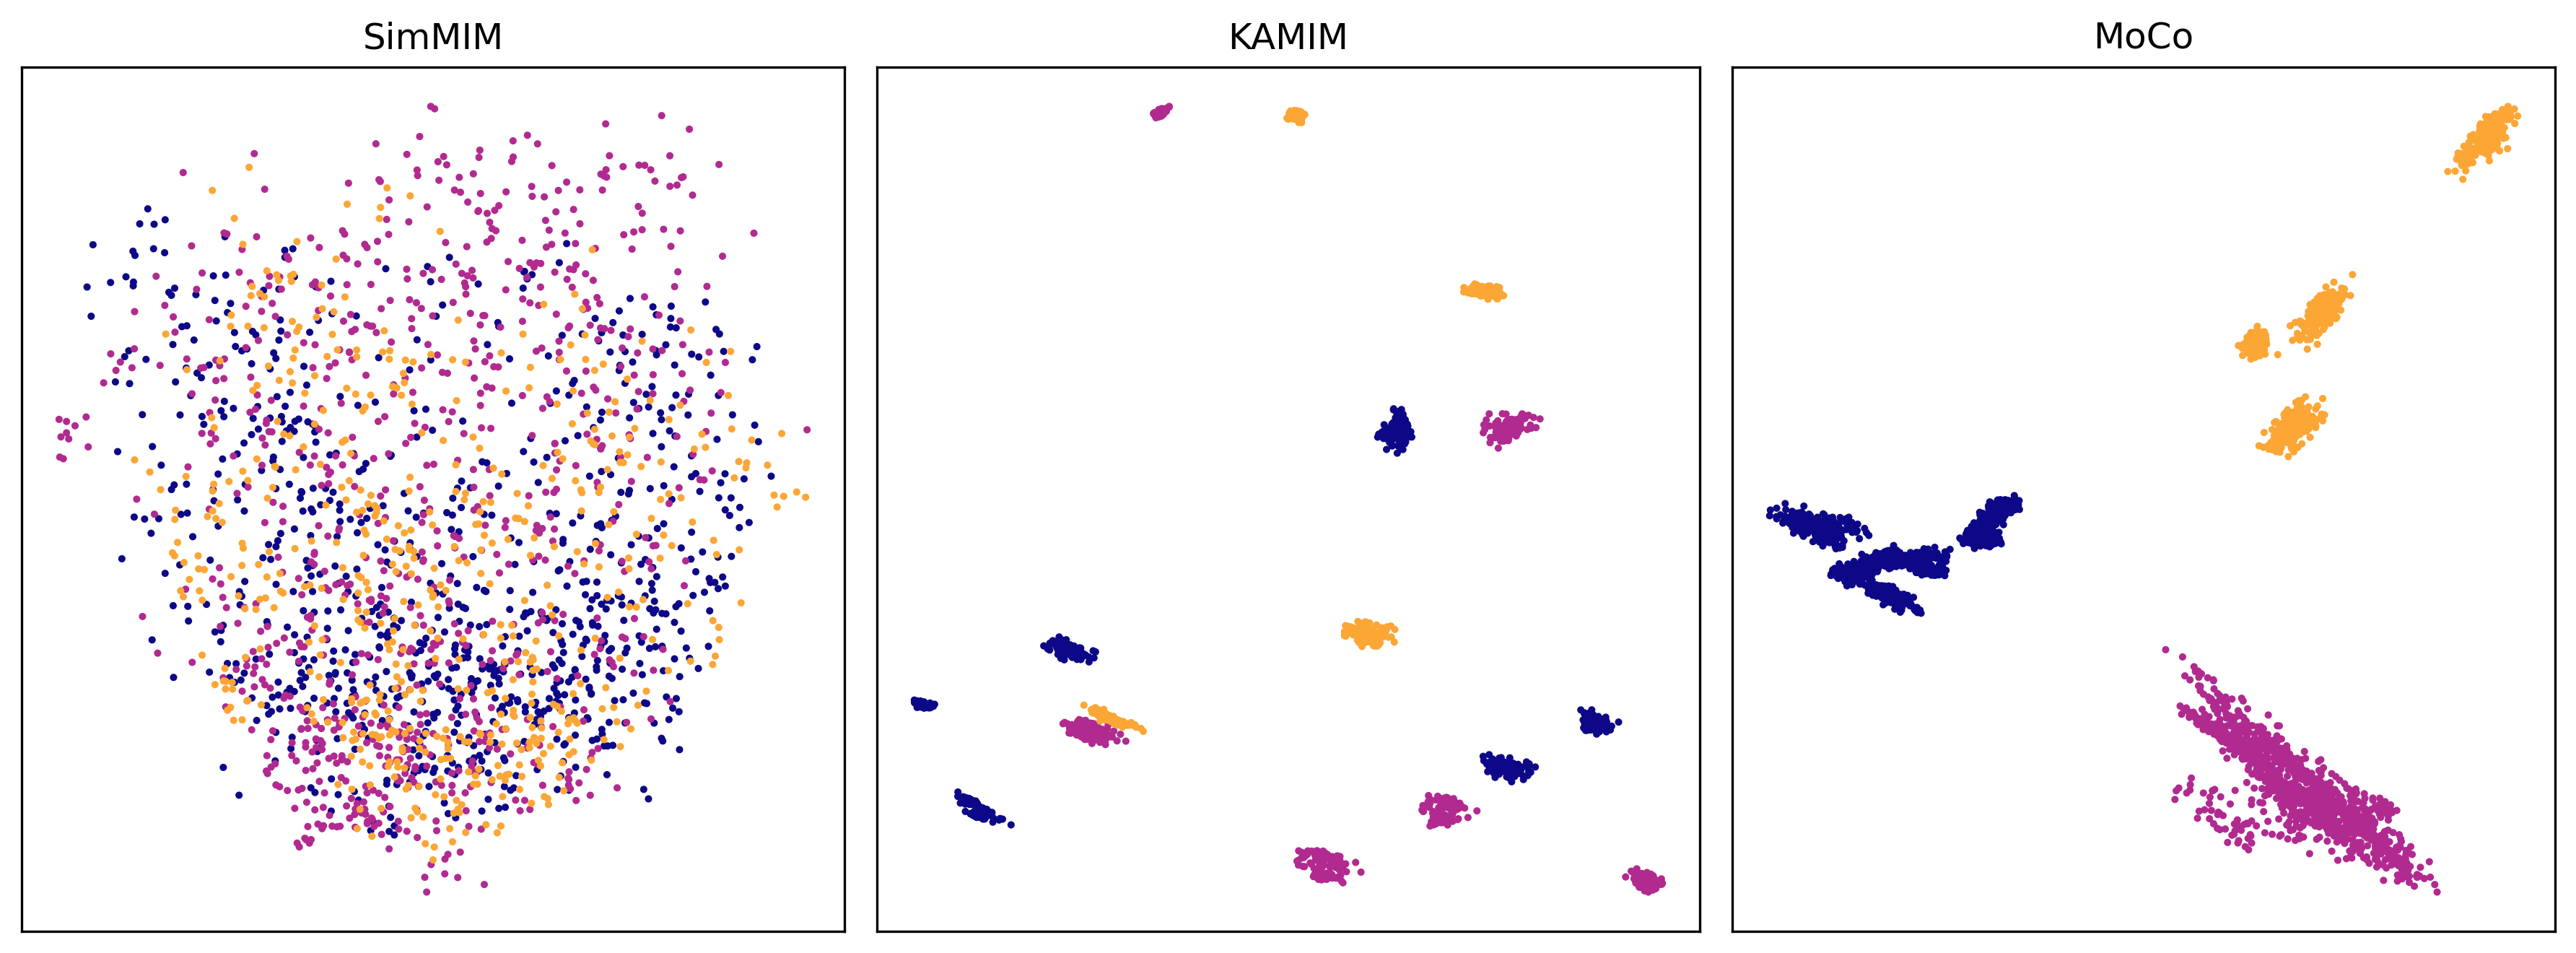

In [14]:
# plotting KAMIM post_attention for different classes

def visualize_post_attn_tokens(ax, zs, attn, depth, ys, moco = False, size = 12, cmap=matplotlib.colormaps["plasma"]): 
    if moco is False:
        pre_attn = attn[depth][0]
        pre_attn = pre_attn[:, 1:, :]
        pre_attn = pre_attn.cpu()
        
        post_attn = attn[depth][1]
        post_attn = post_attn[:,1:,:]  # drop cls
        post_attn = post_attn.cpu()
        
    else:
        pre_attn = attn[4][depth]
        pre_attn = pre_attn[:,1:,:]  # drop cls
        pre_attn = pre_attn.cpu()
        
        post_attn = attn[5][depth]
        post_attn = post_attn[:, 1:, :]
        post_attn = post_attn.cpu()
        
    b, t, e = post_attn.shape
    post_attn = post_attn.reshape(-1, e)
    
    reducer = PCA(n_components=2)
    embedded = reducer.fit_transform(post_attn)

    labels = ys 
    labels = np.array([[label] * size * size for label in labels]).flatten()
    c = [cmap(label / (max(labels) + 0.5)) for label in labels]
    
    ax.scatter(embedded[:,0], embedded[:,1], c=c, s=2)

    
    # ax.legend(bbox_to_anchor=(1.04, 1))
   
 
xs, ys = next(iter(dataset_test))

fig, ax = plt.subplots(1,3, figsize = (12, 5), dpi=300)
ys_np = ys.numpy()

DEPTH = 11
b = [1, 13]

# SimMIM
with torch.no_grad():
    xs = xs.cuda()
    out  = model_simmim(xs, output_hidden_states = True, output_attentions = True)
    zs = out['hidden_states']
    attn = out['attentions']
    zs = zs[:-1]
visualize_post_attn_tokens(ax[0], zs, attn, depth=DEPTH, ys = ys)  # coloring at the image level
ax[0].set_title("SimMIM")

# kamim
with torch.no_grad():
    xs = xs.cuda()
    out  = model_kamim(xs, output_hidden_states = True, output_attentions = True)
    zs = out['hidden_states']
    attn = out['attentions']
    zs = zs[:-1]
visualize_post_attn_tokens(ax[1], zs, attn, depth=DEPTH, ys = ys)  # coloring at the image level
ax[1].set_title("KAMIM")

# moco
with torch.no_grad():
    xs_moco = transform_moco(xs).cuda()
    outs_moco = model_moco(xs_moco)
    pre_attn = outs_moco[-2]
    post_attn = outs_moco[-1]
visualize_post_attn_tokens(ax[2], None, outs_moco, depth=DEPTH, ys = ys, moco = True, size = 14)  # coloring at the image level
ax[2].set_title("MoCo")

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

handles, labels = ax[2].get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', bbox_to_anchor = (0.5,0), ncol = 3)

fig.tight_layout(rect = (0, 0.10, 1, 1))
save_path = 'supp_figures/'
fig.savefig(save_path + 'post_attn_3.pdf', facecolor = 'white')